# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [182]:
# Change here using YOUR first and last names
fn1 = "salma"
ln1 = "el-alaoui-talibi"
fn2 = "sophia"
ln2 = "lazraq"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_el-alaoui-talibi_salma_and_lazraq_sophia.ipynb


In [183]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [184]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

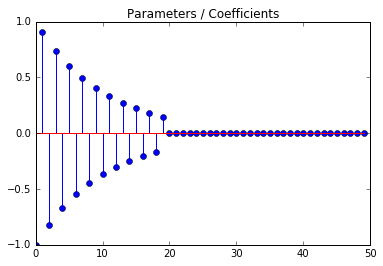

In [185]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [186]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [187]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t""" 
    x_abs = np.absolute(x)
    prox_lasso = np.sign(x) * (x_abs - t * s) * (x_abs > t * s)
    return prox_lasso

def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    lasso = s * np.linalg.norm(x, ord = 1)
    return lasso

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""
    "x/(1+s)"
    return x/(1 + t*s)
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return (s/2) * np.linalg.norm(x) ** 2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

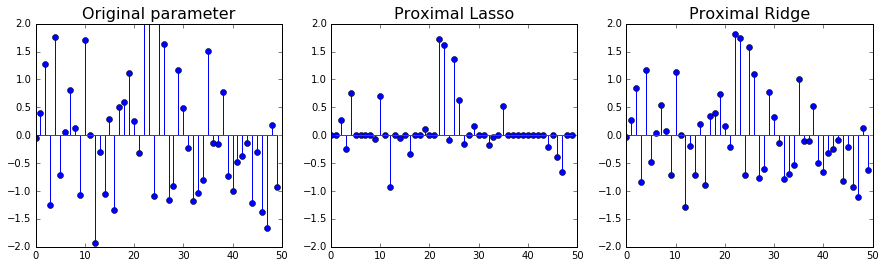

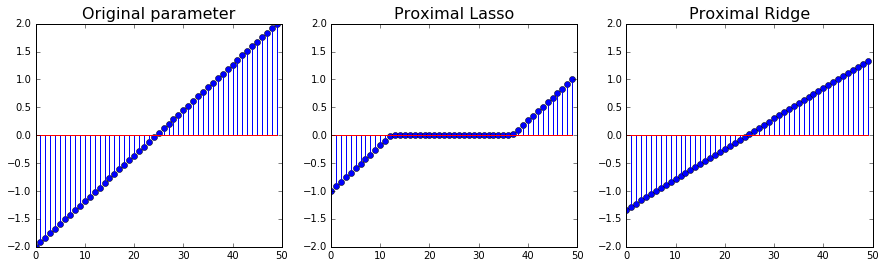

In [188]:
def prox_viz(x):
    l_l1 = 1.
    l_l2 = 0.5
    plt.figure(figsize=(15.0, 4.0))
    plt.subplot(1, 3, 1)
    plt.stem(x)
    plt.title("Original parameter", fontsize=16)
    plt.ylim([-2, 2])
    plt.subplot(1, 3, 2)
    plt.stem(prox_lasso(x, s=l_l1))
    plt.title("Proximal Lasso", fontsize=16)
    plt.ylim([-2, 2])
    plt.subplot(1, 3, 3)
    plt.stem(prox_ridge(x, s=l_l2))
    plt.title("Proximal Ridge", fontsize=16)
    plt.ylim([-2, 2])
    plt.show()

prox_viz(randn(50))
prox_viz(np.linspace(-2,2))


## Question

- Comment what you observe (1 or 2 sentences).

** Answer**

- Both Ridge and Lasso proximals perform a shrinkage towards zero reducing variability. However, we can see that unlike Ridge, Lasso shrinks all the way to zero and therefore introduces sparsity.


## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

**Answers:**

Gradient for Linear regression: 
$$
\nabla f(x) = \frac{1}{n} \ A^\top (AX-b)
$$

Gradient for Logistic regression: 
$$
\nabla f(x) = -\frac{1}{n} \sum_{i=1}^n \frac{b_i a_i^\top exp(-b_i a_i x)}{1 + \exp(-b_i a_i x)}
$$

In [189]:
from scipy.optimize import check_grad

def loss_linreg(x, A, b):
    """Least-squares loss"""
    n_samples = A.shape[0]
    return 1/(2*n_samples) * np.linalg.norm(b - np.dot(A, x)) ** 2

def grad_linreg(x, A, b):
    """Leas-squares gradient"""
    n_samples = A.shape[0]
    return 1/n_samples * np.dot(np.transpose(A), np.dot(A, x) - b)

A, b = simu_linreg(coefs)
print(check_grad(loss_linreg, grad_linreg, coefs, A, b))

def loss_logreg(x, A, b):
    """Logistic loss"""
    n_samples = A.shape[0]
    return 1/n_samples * np.sum(np.log(1+ np.exp(-b * np.dot(A, x))))

def grad_logreg(x, A, b):
    """Logistic gradient"""
    n_samples, n_features = A.shape
    grad = np.zeros(n_features)
    for i in range(n_samples):
        ai = A[i, :]
        bi = b[i]
        grad = grad + (-bi * np.transpose(ai) * np.exp(-bi * np.dot(ai, x))) / (1 + np.exp(-bi * np.dot(ai, x)))
    grad = grad/n_samples  
    return grad

A, b = simu_logreg(coefs)
print(check_grad(loss_logreg, grad_logreg, coefs, A, b))

4.38538191972e-08
6.08207730958e-08


## Part 3: Solvers


We now have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [190]:
from numpy.linalg import norm

def lip_linreg(A):
    """Lipschitz constant for linear square loss"""
    n_samples = A.shape[0]
    return 1/n_samples * np.linalg.norm(np.dot(np.transpose(A), A), ord=2)
    

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    n_samples = A.shape[0]
    return 1/(4*n_samples) * np.linalg.norm(np.dot(np.transpose(A), A), ord=2)

    
def ista(A, b, x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x, A, b) + g(x, s)
    objectives.append(obj)
    
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err", "err objective"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(x=x - step * grad_f(x, A, b), s=s, t=step)
        x = x_new
        obj = f(x, A, b) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
   
    return x, objectives, errors

In [191]:
def fista( A, b, x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x, A, b) + g(x, s)
    objectives.append(obj)
    
    t = 1.
    t_new = 1. 
    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err", "err objective"]]))
        
    for k in range(n_iter + 1):
        x_new = prox_g(x=z - step * grad_f(z, A, b), s=s, t=step)
        t_new = (1 + np.sqrt(1 + 4 * t * t)) / 2.
        z = x_new + ((t - 1) / t_new) * (x_new - x)
        t = t_new
        x = x_new
        obj = f(x, A, b) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [192]:
# Some definitions before launching the algorithms
def compute_precise_minimum(A, b, f, grad_f, g, prox_g, step, x_true):
    """computes a precise minimum using the fista algorithm"""
    x0 = np.zeros(n_features)
    n_iter = 1000
    s = 1e-2
    x_fista, obj_fista, err_fista = fista(A=A, b=b, x0=x0, f=f, grad_f=grad_f, g=g, prox_g=prox_g, step =1/L, s=s, n_iter=n_iter, 
                                      x_true=coefs, verbose=False)
    obj_star = obj_fista[-1]
    x_star = x_fista
    return obj_star, x_star


In [193]:
A, b = simu_linreg(coefs)
L = lip_linreg(A)
x0 = np.zeros(n_features)
s = 1e-2

#precise minimum and precise minimiser for linear regression with ridge penalization 
obj_star, x_star = compute_precise_minimum(A=A, b=b, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, step=1/L, x_true=coefs)

# Comparison between ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer.
n_iter = 40
x_fista, obj_fista, err_fista = fista(A=A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=x_star, verbose=False)
x_ista, obj_ista, err_ista = ista(A= A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=x_star, verbose=False)
dis_min_ista = obj_ista - obj_star
dis_min_fista = obj_fista - obj_star

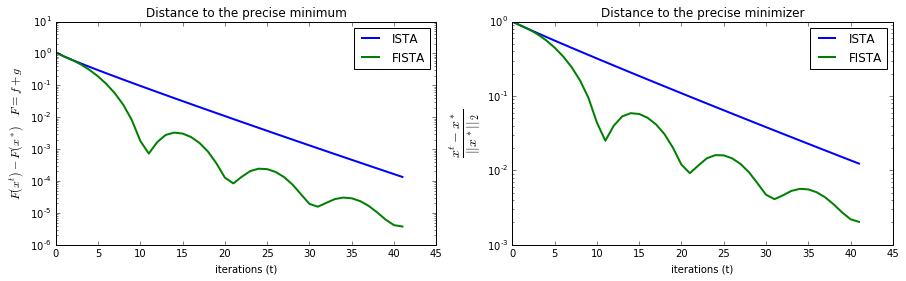

In [194]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.semilogy(dis_min_ista, label="ISTA", lw=2)
plt.semilogy(dis_min_fista, label="FISTA", lw=2)
plt.xlabel('iterations (t)')
plt.ylabel(r'$F(x^t) - F(x^*) \quad F=f+g$', size=12)
plt.title("Distance to the precise minimum")
plt.legend()
plt.subplot(1, 2, 2)
plt.semilogy(err_ista, label="ISTA", lw=2)
plt.semilogy(err_fista, label="FISTA", lw=2)
plt.xlabel('iterations (t)')
plt.title("Distance to the precise minimizer")
plt.ylabel(r'$\frac{x^t - x^*}{||x^*||_2}$', size=20)
plt.legend()
plt.show()

**Comparison between the convergences of ISTA and FISTA**

For ISTA, we can see that the difference between the value of $F(x^t)$ of the $t^{th}$ iterate and the precise minimum we have computed beforehand $F(x^*)$ decreases at a **linear rate**, as the error decay on the this algorithmic scale is linear with a negative slope. The improvement from the the sublinear convergence rate is due to the fact that the loss function f here (least squares loss) is both L-smooth and strongly convex.

For FISTA, we first note that the error and thus the iterates $F(x^t)$ are not **strictly** decreasing. We can also see that FISTA has a linear convergence rate as well, only with a steeper slope (which is the square root of the condition number). 


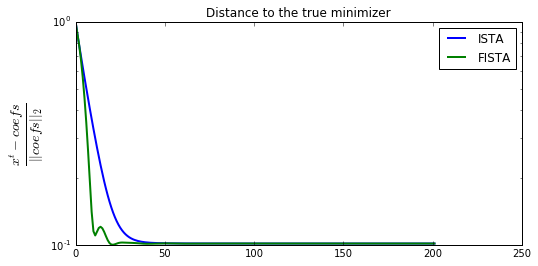

In [195]:
# Comparison between ISTA and FISTA, in terms of distance to the minimum and distance to the true minimizer.
n_iter = 200
_, _, err_fista = fista(A=A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=coefs, verbose=False)
_, _, err_ista = ista(A= A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=coefs, verbose=False)
plt.figure(figsize=(8.0, 4.0))
plt.semilogy(err_ista, label="ISTA", lw=2)
plt.semilogy(err_fista, label="FISTA", lw=2)
plt.title("Distance to the true minimizer")
plt.ylabel(r'$\frac{x^t - coefs}{||coefs||_2}$', size=20)
plt.legend()
plt.show()

Here, we plot the distance to the true coefficients of the model that we are trying to uncover, and we see that both the ISTA and FISTA methods converge to the same difference (error).

**Results for Logistic Regression**

In [196]:
A, b = simu_logreg(coefs)
L = lip_logreg(A)
x0 = np.zeros(n_features)
s = 1e-2

#precise minimum and precise minimiser for linear regression with ridge penalization 
obj_star, x_star = compute_precise_minimum(A=A, b=b, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, step=1/L, x_true=coefs)

# Comparison between ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer.
n_iter = 40
x_fista, obj_fista, err_fista = fista(A=A, b=b, x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=x_star, verbose=False)
x_ista, obj_ista, err_ista = ista(A= A, b=b, x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=x_star, verbose=False)
dis_min_ista = obj_ista - obj_star
dis_min_fista = obj_fista - obj_star

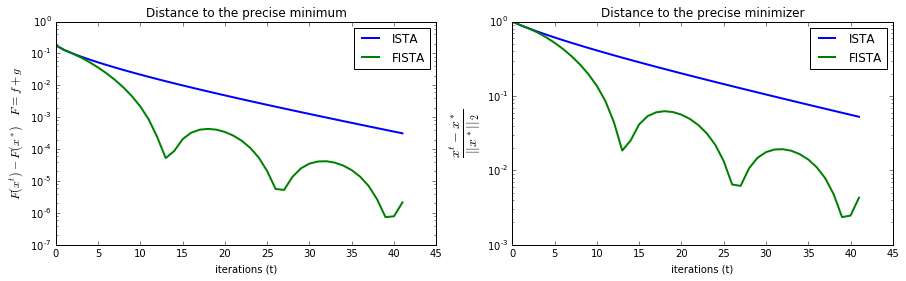

In [197]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.semilogy(dis_min_ista, label="ISTA", lw=2)
plt.semilogy(dis_min_fista, label="FISTA", lw=2)
plt.xlabel('iterations (t)')
plt.ylabel(r'$F(x^t) - F(x^*) \quad F=f+g$', size=12)
plt.title("Distance to the precise minimum")
plt.legend()
plt.subplot(1, 2, 2)
plt.semilogy(err_ista, label="ISTA", lw=2)
plt.semilogy(err_fista, label="FISTA", lw=2)
plt.xlabel('iterations (t)')
plt.title("Distance to the precise minimizer")
plt.ylabel(r'$\frac{x^t - x^*}{||x^*||_2}$', size=20)
plt.legend()
plt.show()

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

**Answers**

Because we have already discussed the convergence rates previously; and because computing a precise minimum for each case is computationnaly expensive, we choose to plot for all the questions below the difference between the minimizer at each iteration $t$ and the model coefficients that we are trying to recover: $\frac{x^t - coefs}{||coefs||_2}$. We think this will allow us to assess both the influence of the different parameters both on the speed of the algorithm as well as on its accuracy.

**Question 1**

In [198]:
# Question 1
def compare_correlation(algorithm, linear, n_iter_1, n_iter_2, corr_values= [0.1, 0.2, 0.5, 0.7, 0.9]):
    # ISTA or FISTA
    algo_name = algorithm.__name__.upper()
    if linear:
        regression_type = "Linear Ridge Regression"
        f=loss_linreg
        grad_f=grad_linreg
        l_func=lip_linreg
        simu_func=simu_linreg
    else:
        regression_type = "Logistic Ridge Regression"
        f=loss_logreg
        grad_f=grad_logreg
        l_func=lip_logreg
        simu_func=simu_logreg
        
    plt.figure(figsize=(15.0, 4.0))
    for corr in corr_values:
        # parameter definition
        A, b = simu_func(coefs, corr=corr)
        L = l_func(A)
        x0 = np.zeros(n_features)
        s = 1e-2
        # ista and fista convergence plots
        _, _, err_1 = algorithm(A=A, b=b, x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter_1, 
                                      x_true=coefs, verbose=False)
        _, _, err_2 = algorithm(A=A, b=b, x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter_2, 
                                      x_true=coefs, verbose=False)
        plt.subplot(1, 2, 1)
        plt.semilogy(err_1, label=r"corr="+str(corr), lw=2)
        plt.title("Distance to the minimizer, number of iterations = " + str(n_iter_1))
        plt.legend(loc='lower right')
        plt.subplot(1, 2, 2)
        plt.semilogy(err_2, label=r"corr="+str(corr), lw=2)
        plt.title("Distance to the minimizer, number of iterations = " + str(n_iter_2))
        plt.legend(loc='lower right')
        plt.suptitle("Convergence plots for different values of Correlation for " + algo_name + "\n for " + regression_type,  size=14, y=1.1)
    plt.show()
        

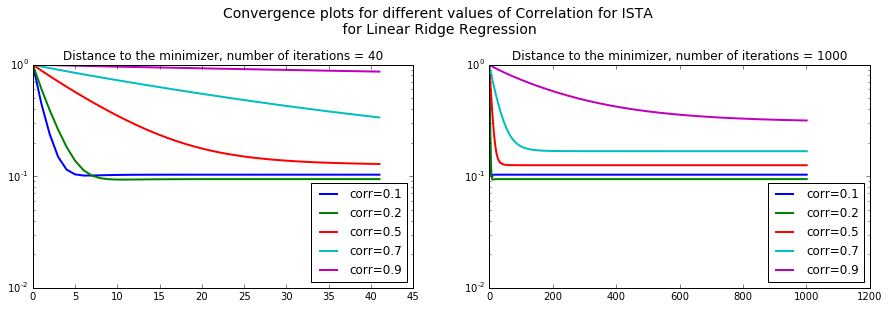

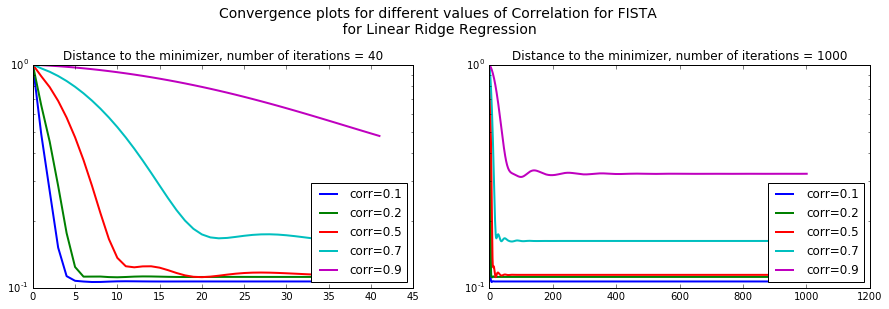

In [199]:
compare_correlation(ista, linear=True, n_iter_1 = 40, n_iter_2 = 1000)
compare_correlation(fista, linear=True,  n_iter_1 = 40, n_iter_2 = 1000)


**Impact of correlation in Linear Regression**

We can see that for both ISTA and FISTA, the higher the correlation, the slower the convergence rate, and the higher the error $\frac{x^t - coefs}{||coefs||_2}$. We also note that FISTA seems to reduce the differences between the achieved errors for close values of correlation. 


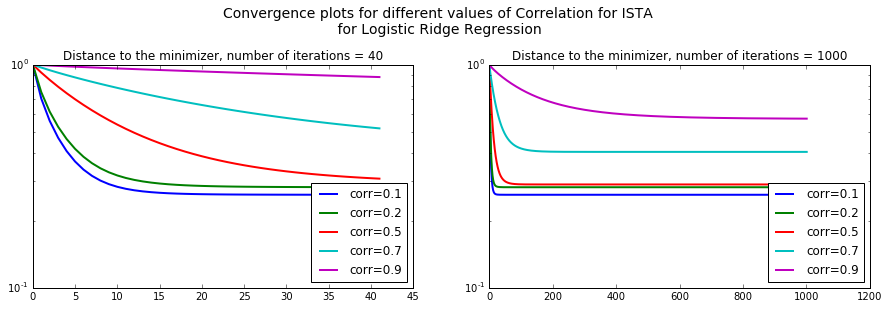

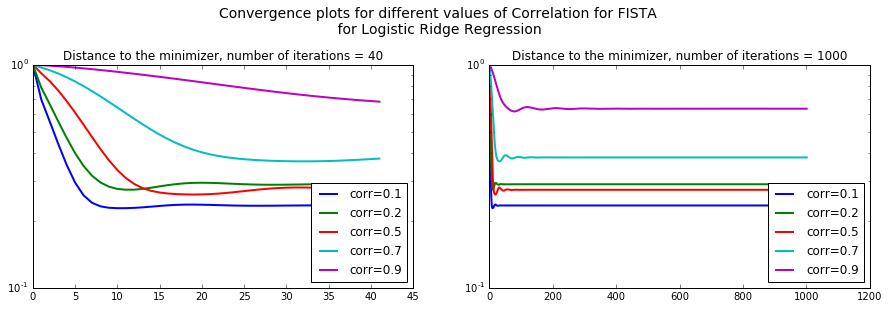

In [200]:
compare_correlation(ista, linear=False, n_iter_1 = 40, n_iter_2 = 1000)
compare_correlation(fista, linear=False,  n_iter_1 = 40, n_iter_2 = 1000)

**Impact of correlation in Logistic Regression**

We can see that for both ISTA and FISTA, the higher the correlation, the slower the convergence rate, and the higher the error $\frac{x^t - coefs}{||coefs||_2}$, although the differences seem to be less important for lower values of correlation, compared to Linear Regression.

**Question 2**

In [201]:
# Question 2
def compare_level_penalization(algorithm, linear, n_iter_1, n_iter_2, level_values =[1e-3, 1e-2, 1e-1, 1]):
    # ISTA or FISTA
    algo_name = algorithm.__name__.upper()
    if linear:
        regression_type = "Linear Ridge Regression"
        f=loss_linreg
        grad_f=grad_linreg
        l_func=lip_linreg
        simu_func=simu_linreg
        A, b = simu_func(coefs)
        L = l_func(A)
    else:
        regression_type = "Logistic Ridge Regression"
        f=loss_logreg
        grad_f=grad_logreg
        l_func=lip_logreg
        simu_func=simu_logreg
        A, b = simu_func(coefs)
        L = l_func(A)  
    plt.figure(figsize=(15.0, 4.0))
    for s in level_values:
        # parameter definition
        x0 = np.zeros(n_features)
        # ista and fista convergence plots
        _, _, err_1 = algorithm(A=A, b=b, x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter_1, 
                                      x_true=coefs, verbose=False)
        _, _, err_2 = algorithm(A=A, b=b, x0=x0, f=f, grad_f=grad_f, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter_2, 
                                      x_true=coefs, verbose=False)
        plt.subplot(1, 2, 1)
        plt.semilogy(err_1, label=r"level="+str(s), lw=2)
        plt.title("Distance to the minimizer, number of iterations = " + str(n_iter_1))
        plt.legend(loc='lower right')
        plt.subplot(1, 2, 2)
        plt.semilogy(err_2, label=r"level="+str(s), lw=2)
        plt.title("Distance to the minimizer, number of iterations = " + str(n_iter_2))
        plt.legend(loc='lower right')
        plt.suptitle("Convergence plots for different penalization levels of Correlation for " + algo_name + "\n for " + regression_type,  size=14, y=1.1)
    plt.show()

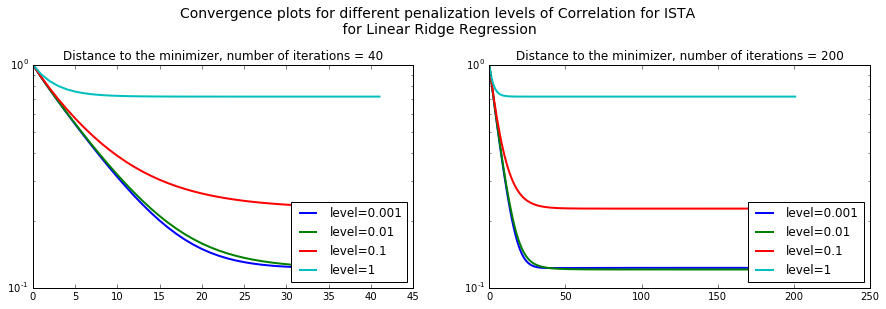

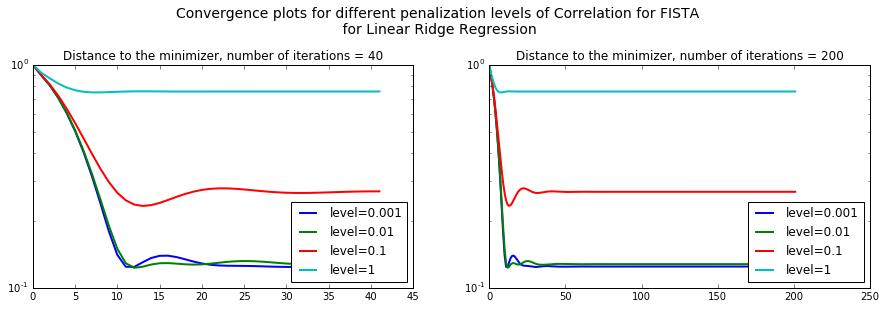

In [202]:
compare_level_penalization(ista, linear=True, n_iter_1 = 40, n_iter_2 = 200)
compare_level_penalization(fista, linear=True,  n_iter_1 = 40, n_iter_2 = 200)

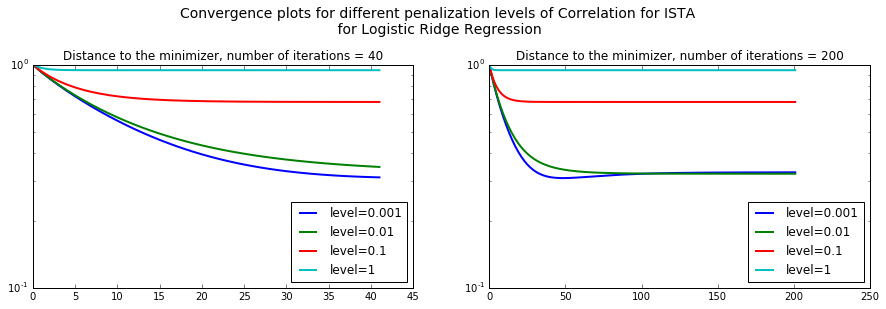

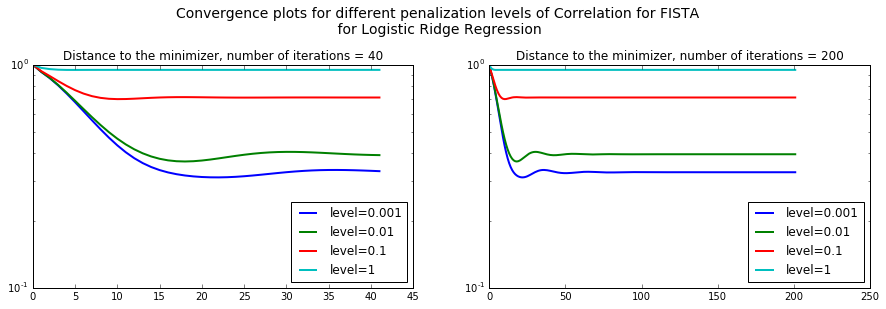

In [203]:
compare_level_penalization(ista, linear=False, n_iter_1 = 40, n_iter_2 = 200)
compare_level_penalization(fista, linear=False,  n_iter_1 = 40, n_iter_2 = 200)

**Impact of the level of Ridge penalization in Linear and Logistic regressions:**

In ISTA for both Linear and Logistic Regression, we note that the smaller the level of Ridge penalization, the better the error and the convergence rate, which makes sense because a higher $s$ induces **higer bias** in the solution.

For FISTA, the same conculsions apply to higher values of the level of penalization $s$.

**Question 3**

In [204]:
# Question 3
def compare_type_penalization(algorithm, linear, n_iter, corr):
    # ISTA or FISTA
    algo_name = algorithm.__name__.upper()
    s = 1e-2
    if linear:
        regression_type = "Linear Regression"
        f=loss_linreg
        grad_f=grad_linreg
        l_func=lip_linreg
        simu_func=simu_linreg
    else:
        regression_type = "Logistic Regression"
        f=loss_logreg
        grad_f=grad_logreg
        l_func=lip_logreg
        simu_func=simu_logreg
        
    plt.figure(figsize=(15.0, 4.0))
    for g, prox_g in [(ridge, prox_ridge), (lasso, prox_lasso)]:
        # parameter definition
        x0 = np.zeros(n_features)
        # ista and fista convergence plots
        for (i,c) in enumerate(corr):
            A, b = simu_func(coefs, corr=c)
            L = l_func(A)
            _, _, err = algorithm(A=A, b=b, x0=x0, f=f, grad_f=grad_f, g=g, prox_g=prox_g, step =1/L, s=s, n_iter=n_iter, 
                                      x_true=coefs, verbose=False)
            plt.subplot(1, len(corr), i+1)
            plt.semilogy(err, label=g.__name__, lw=2)
            if i == 0:
                plt.ylabel(r'$\frac{x^t - coefs}{||coefs||_2}$', size = 20)
            plt.title("correlation = " + str(c))
            plt.legend(loc='lower right')
        plt.suptitle("Convergence plots for Ridge and Lasso penalizations for " + algo_name + "\n for " + regression_type,  size=14, y=1.1)
    plt.show()

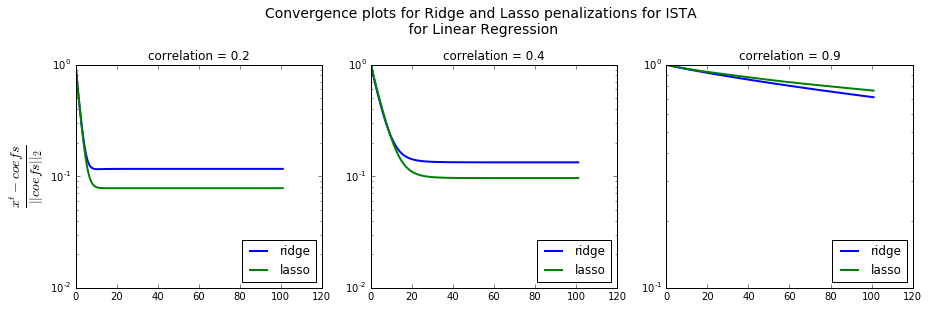

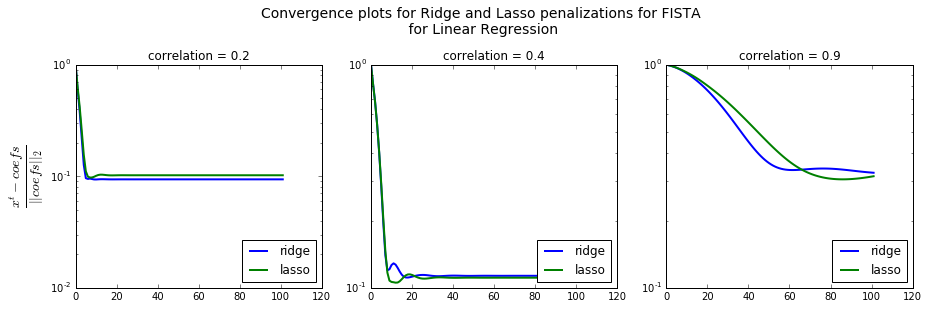

In [205]:
compare_type_penalization(ista, linear=True, n_iter=100, corr=[0.2, 0.4, 0.9])
compare_type_penalization(fista, linear=True, n_iter=100, corr=[0.2, 0.4, 0.9])

**Performance of Ridge penalization compared to Lasso penalization**

In Linear Regression, for lower values of correlation, the lasso solution dominates the ridge solution, which is due to the sparsity of the true coefficients of the model. For higher values of correlation, the ridge solution is better,  as the lasso will tend to select only one feature among features with high pairwise correlations. 

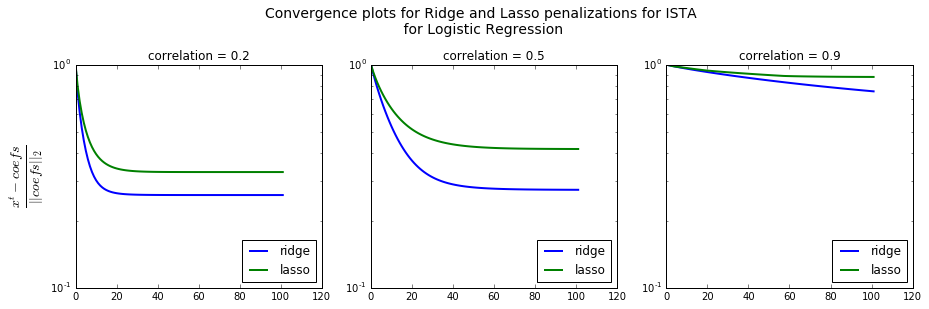

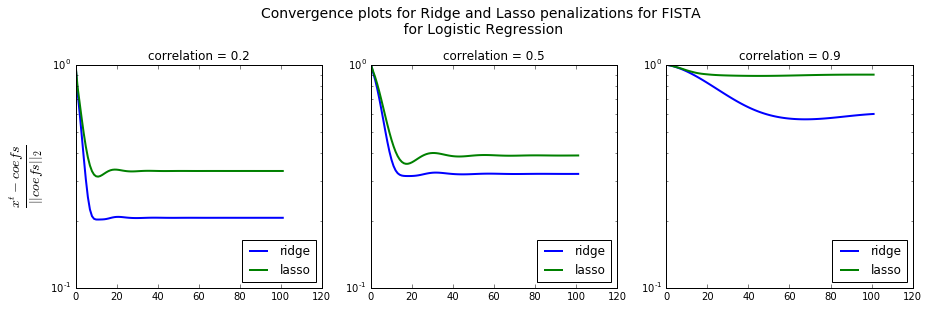

In [206]:
compare_type_penalization(ista, linear=False, n_iter=100, corr=[0.2, 0.5, 0.9])
compare_type_penalization(fista, linear=False, n_iter=100, corr=[0.2, 0.5, 0.9])

**Performance of Ridge penalization compared to Lasso penalization**

In logistic Regression, the ridge solution dominates the lasso solution both in term of error and convergence rate, for all values of correlation.

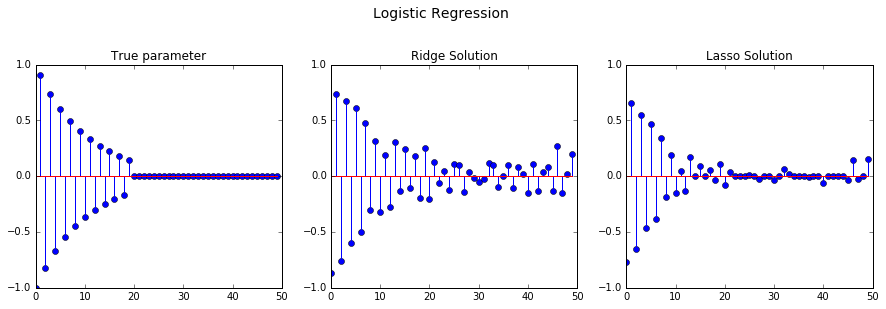

In [207]:
A, b = simu_logreg(coefs, corr=0.5)
L = lip_logreg(A)
n_iter = 1000
x0 = np.zeros(n_features)
s = 1e-2
x_fista_ridge,_, _ = fista(A=A, b=b, x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=coefs, verbose=False)
x_fista_lasso,_, _ = fista(A=A, b=b, x0=x0, f=loss_logreg, grad_f=grad_logreg, g=lasso, prox_g=prox_lasso, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=coefs, verbose=False)
plt.figure(figsize=(15.0, 4.0))
# Estimated parameters using ISTA, FISTA and fista
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.ylim([-1, 1])
plt.title("True parameter")
plt.subplot(1, 3, 2)
plt.stem(x_fista_ridge)
plt.ylim([-1, 1])
plt.title("Ridge Solution")
plt.subplot(1, 3, 3)
plt.stem(x_fista_lasso)
plt.ylim([-1, 1])
plt.title("Lasso Solution")
plt.suptitle("Logistic Regression", y =1.1, size=14)

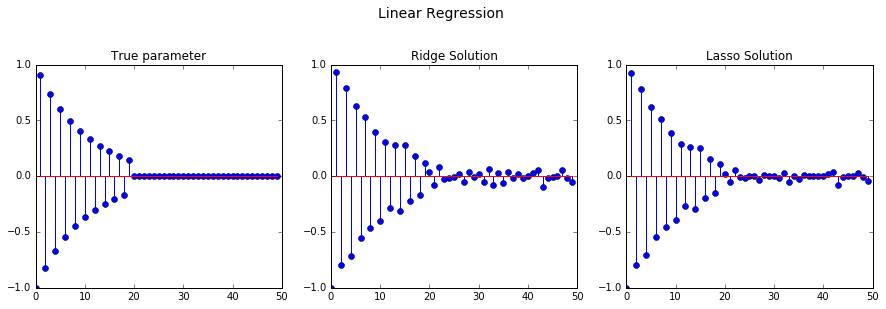

In [208]:
A, b = simu_linreg(coefs, corr=0.5)
L = lip_linreg(A)
n_iter = 1000
x0 = np.zeros(n_features)
s = 1e-2
x_fista_ridge,_, _ = fista(A=A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=coefs, verbose=False)
x_fista_lasso,_, _ = fista(A=A, b=b, x0=x0, f=loss_linreg, grad_f=grad_linreg, g=lasso, prox_g=prox_lasso, step =1/L, s=s, n_iter=n_iter, 
                                  x_true=coefs, verbose=False)
plt.figure(figsize=(15.0, 4.0))
# Estimated parameters using ISTA, FISTA and fista
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.ylim([-1, 1])
plt.title("True parameter")
plt.subplot(1, 3, 2)
plt.stem(x_fista_ridge)
plt.ylim([-1, 1])
plt.title("Ridge Solution")
plt.subplot(1, 3, 3)
plt.stem(x_fista_lasso)
plt.ylim([-1, 1])
plt.title("Lasso Solution")
plt.suptitle("Linear Regression", y =1.1, size=14)